# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: HTR with Synthetic Friedman Data 

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython and spotRiver).
* The hyperparameter software SPOT was developed in R (statistical programming language), see Open Access book "Hyperparameter Tuning for Machine and Deep Learning with R - A Practical Guide", available here: [https://link.springer.com/book/10.1007/978-981-19-5170-1](https://link.springer.com/book/10.1007/978-981-19-5170-1).

* This notebook demonstrates hyperparameter tuning for `river`. It is based on the notebook "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).

In [1]:
pip list | grep  "spot[RiverPython]"

spotPython                                0.0.11
spotRiver                                 0.0.14
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython


## Example 1: HTR Hyperparameter

In [3]:
import calendar
import math
import datetime as dt
import numpy as np
from math import inf
from spotPython.spot import spot
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.utils.selectors import select_leaf_prediction
from spotRiver.utils.selectors import select_leaf_model
from spotRiver import data
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from river import datasets
from river import time_series
from river import utils
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

### 1 The Objective Function 

* Here we will use the river `HTR` function as in "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).

## River's Synth Data Example

In [4]:
from river.datasets import synth
n_samples = 10_000
data = synth.Friedman(seed=42).take(n_samples)
dataset  = list(data)

* Take a look at the data:

In [5]:
for x,y in dataset:
    print(x,y)
    break

{0: 0.6394267984578837, 1: 0.025010755222666936, 2: 0.27502931836911926, 3: 0.22321073814882275, 4: 0.7364712141640124, 5: 0.6766994874229113, 6: 0.8921795677048454, 7: 0.08693883262941615, 8: 0.4219218196852704, 9: 0.029797219438070344} 7.6612066799391085


## Define hyperparameter

* The `river` model (`HTR`) is selected.
* Furthermore, the corresponding hyperparameters, see: [https://riverml.xyz/0.15.0/api/tree/HoeffdingTreeRegressor/](https://riverml.xyz/0.15.0/api/tree/HoeffdingTreeRegressor/) are selected (incl. type information, names, and bounds).

In [6]:
fun = HyperRiver(seed=123, log_level=20).fun_HTR_iter_progressive
var_type = ["int"] * 2 + ["num"] * 2 + ["factor"] * 2 + ["num"] + ["int"] * 2 + ["factor"] + ["num"]

var_name=["gracePeriod", "maxDepth", "delta", "tau", "leafPrediction",
          "leafModel", "modelSelDecay", "splitter",
          "minSamplesSplit", "binarySplit", "maxSize"]
lower = np.array([100, 1,  1e-8, 0.025, 0, 0, 0.8,   0,  5, 0, 250.0])
upper = np.array([200, 6,  1e-6, 0.075, 2, 2, 0.975, 2, 10, 1, 750.0])
fun_control = {"data": dataset,
               "n_samples": n_samples,
               "weights": np.array([1, 1/200, 1/200])*10_000.0,
               "step": 1000,
               "log_level": 50,
               "weight_coeff": 1.0,
               "metric": metrics.MAE()}

### 3 Run the `Spot` Optimizer

* Run SPOT for approx. 5 mins (`max_time`).
* Note: the run takes longer, because the evaluation time of initial design (here: `initi_size`, 20 points) is not considered.

In [7]:
spot_htr = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 10,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   var_name=var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 10,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 11,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      "log_level": 50
                                      })
spot_htr.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results

* Show the Progress of the hyperparameter tuning:

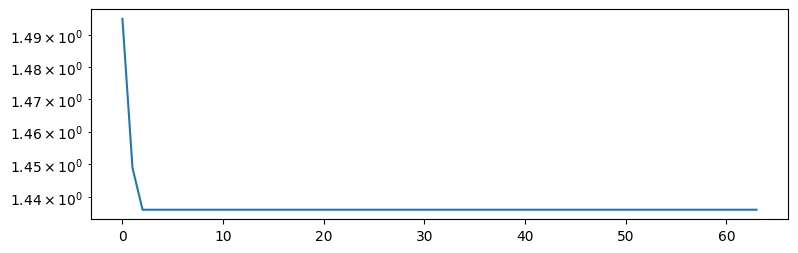

In [8]:
spot_htr.plot_progress(log_y=True)



* Print the Results

In [9]:
spot_htr.print_results()

min y: 1.4362757060363853
gracePeriod: 128.0
maxDepth: 1.0
delta: 5.948752696222902e-07
tau: 0.02996276270809942
leafPrediction: 0.0
leafModel: 2.0
modelSelDecay: 0.8794622456969815
splitter: 1.0
minSamplesSplit: 8.0
binarySplit: 0.0
maxSize: 644.5464281687503


## Show variable importance

In [10]:
spot_htr.print_importance()

Importance relative to the most important parameter:
gracePeriod:  100.0
maxDepth:  0.026053033148974496
delta:  100.0
tau:  1.5567378945597647e-05
leafPrediction:  0.018934275221622936
leafModel:  100.0
modelSelDecay:  100.0
splitter:  1.6648499669941735e-05
minSamplesSplit:  88.24882906920249
binarySplit:  0.104331261811666
maxSize:  100.0


## Build and Evaluate HTR Model with Tuned Hyperparameters

In [11]:
X = spot_htr.to_all_dim(spot_htr.min_X.reshape(1,-1))
print(X)
grace_period = X[:, 0]
max_depth = X[:, 1]
delta = X[:, 2]
tau = X[:, 3]
leaf_prediction = X[:, 4]
leaf_model = X[:, 5]
model_selector_decay = X[:, 6]
splitter = X[:, 7]
min_samples_split = X[:, 8]
binary_split = X[:, 9]
max_size = X[:, 10]


[[1.28000000e+02 1.00000000e+00 5.94875270e-07 2.99627627e-02
  0.00000000e+00 2.00000000e+00 8.79462246e-01 1.00000000e+00
  8.00000000e+00 0.00000000e+00 6.44546428e+02]]


In [12]:
import numbers
from river import tree
from spotRiver.evaluation.eval_oml import fun_eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.utils.selectors import select_splitter
from spotRiver.utils.selectors import select_max_depth
num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
cat = compose.SelectType(str) | preprocessing.FeatureHasher(n_features=1000, seed=1)
res = eval_oml_iter_progressive(
    dataset=fun_control["data"],
    step=fun_control["step"],
    log_level=20,
    metric=metrics.MAE(),
    models={
         "Default: HTR + QO": (
             (num + cat) | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        "Tuned with SPOT: HTR": (
            (num + cat) | tree.HoeffdingTreeRegressor(
                grace_period=int(grace_period),
                max_depth=select_max_depth(int(max_depth)),
                delta=float(delta),
                tau=float(tau),
                leaf_prediction=select_leaf_prediction(int(leaf_prediction)),
                leaf_model=select_leaf_model(int(leaf_model)),
                splitter=select_splitter(int(splitter)),
                min_samples_split=int(min_samples_split),
                binary_split=int(binary_split),
                max_size=float(max_size)
            )
        ),
    }
)
y = fun_eval_oml_iter_progressive(res, metric=None)

Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...


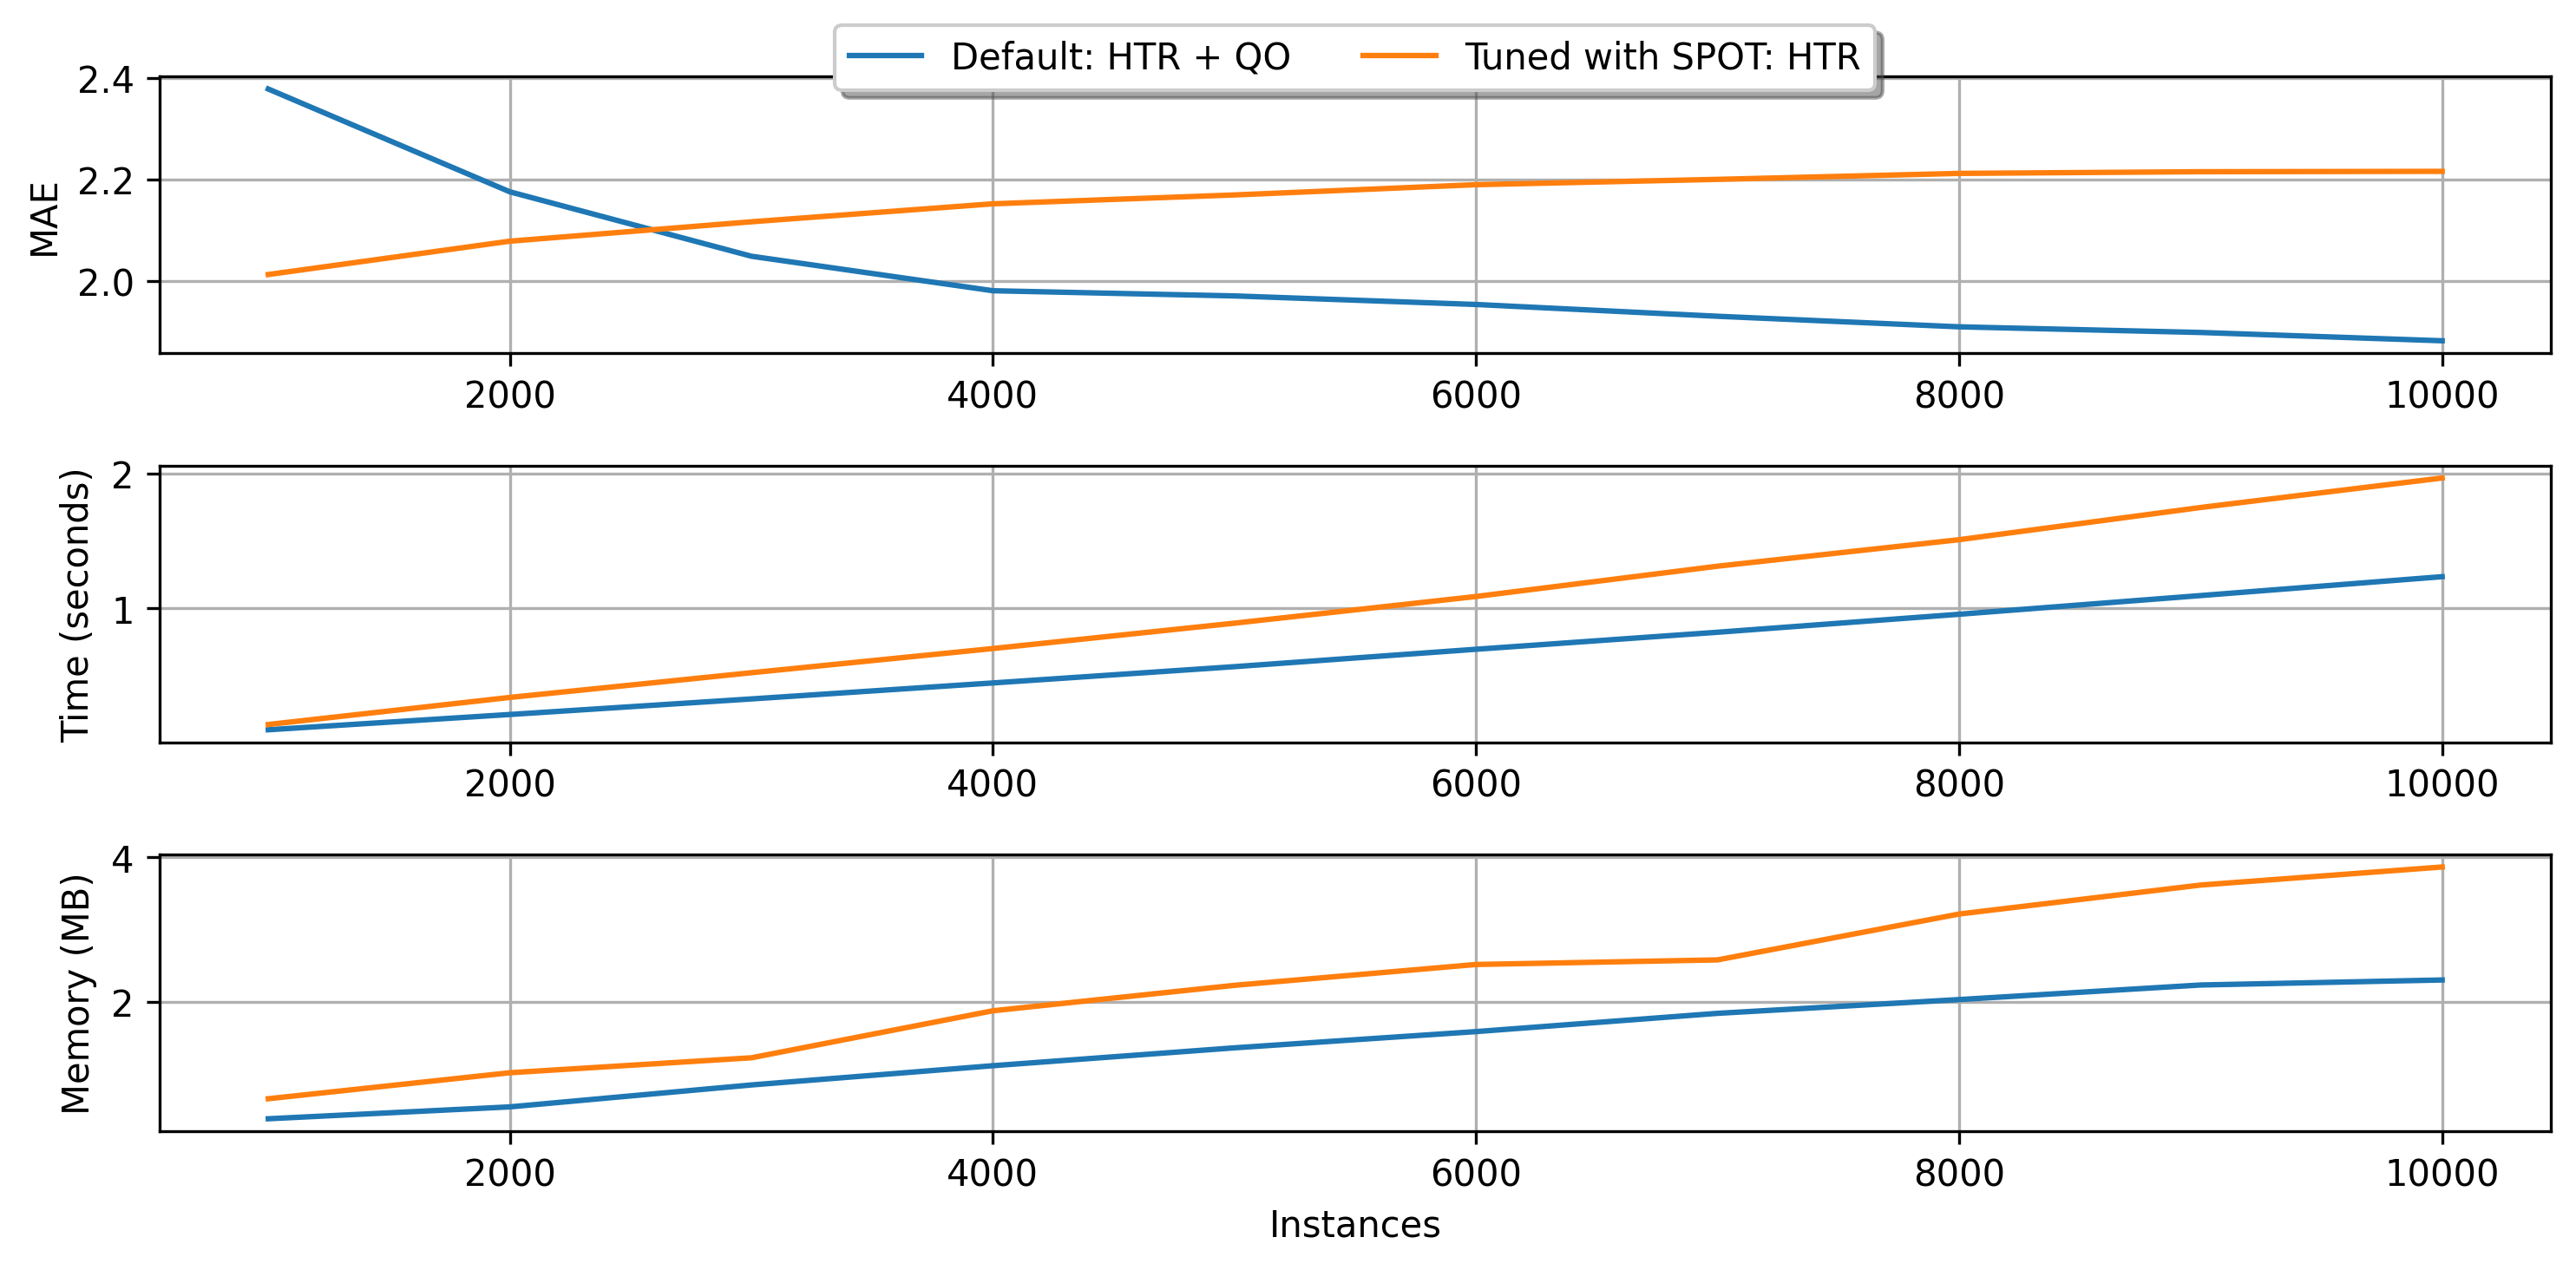

In [13]:
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
plot_oml_iter_progressive(res, log_y=False)

## Visualize Regression Trees

In [14]:
models={
         "Default: HTR + QO": (
                tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        "Tuned with SPOT: HTR": (
                tree.HoeffdingTreeRegressor(
                grace_period=int(grace_period),
                max_depth=select_max_depth(int(max_depth)),
                delta=float(delta),
                tau=float(tau),
                leaf_prediction=select_leaf_prediction(int(leaf_prediction)),
                leaf_model=select_leaf_model(int(leaf_model)),
                splitter=select_splitter(int(splitter)),
                min_samples_split=int(min_samples_split),
                binary_split=int(binary_split),
                max_size=float(max_size)
            )
        ),
    }

In [15]:
models["Default: HTR + QO"]

HoeffdingTreeRegressor (
  grace_period=200
  max_depth=inf
  delta=1e-07
  tau=0.05
  leaf_prediction="adaptive"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=QOSplitter (
    radius=0.25
    allow_multiway_splits=False
  )
  min_samples_split=5
  binary_split=False
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

In [16]:
model_default = models["Default: HTR + QO"]

for x, y in fun_control["data"]:
    ((num + cat) | model_default.learn_one(x, y)    )

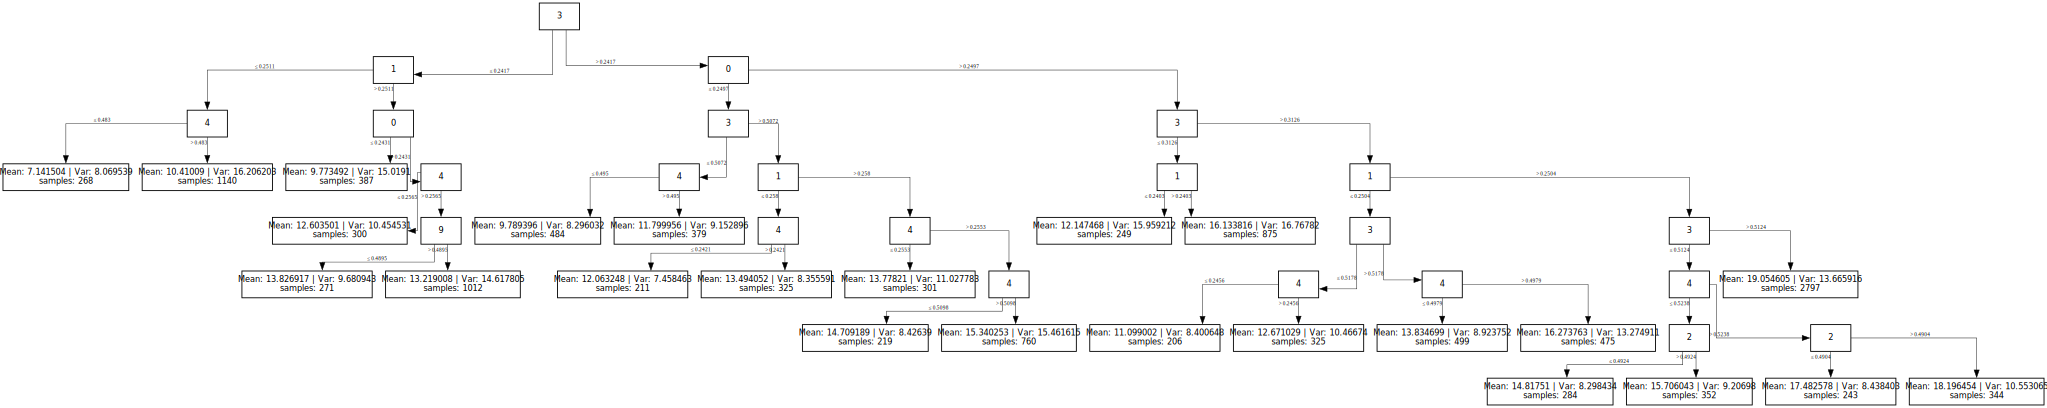

In [17]:
model_default.draw()

In [18]:
model_spot = models["Tuned with SPOT: HTR"]
for x, y in fun_control["data"]:
    ((num + cat) | model_spot.learn_one(x, y)    )

In [19]:
model_spot

HoeffdingTreeRegressor (
  grace_period=128
  max_depth=10
  delta=6e-07
  tau=0.029963
  leaf_prediction="mean"
  leaf_model=Perceptron (
    l2=0.
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=TEBSTSplitter (
    digits=1
  )
  min_samples_split=8
  binary_split=0
  max_size=644.546428
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

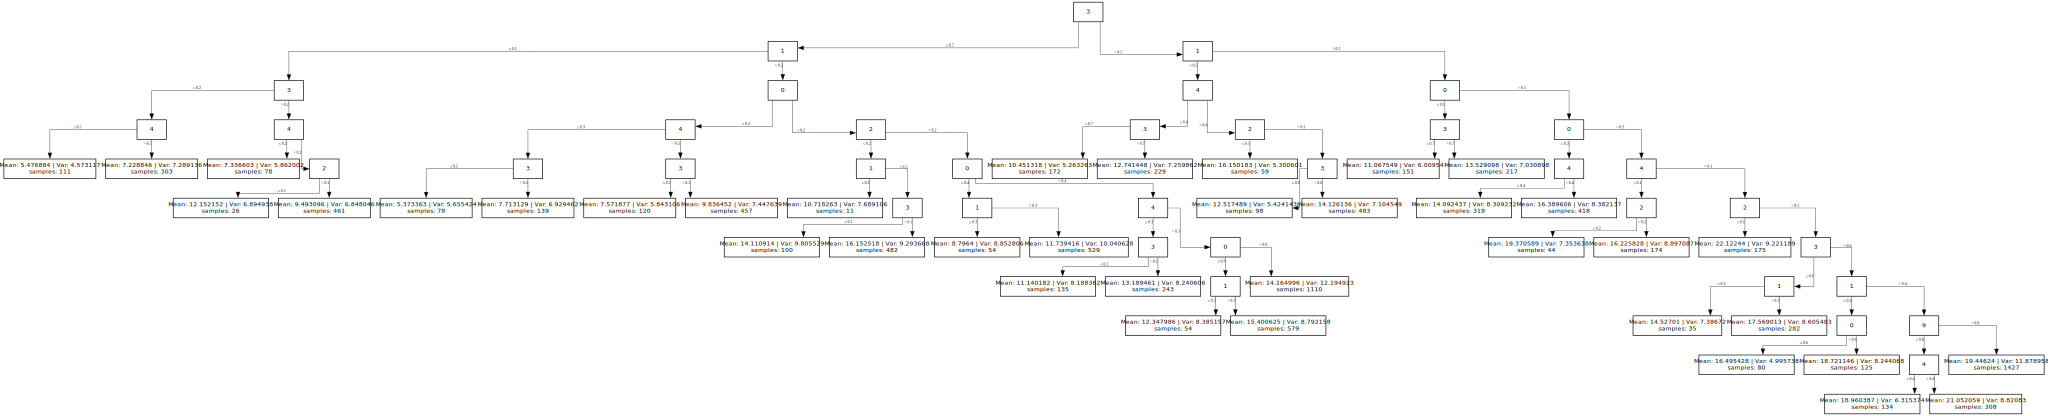

In [20]:
model_spot.draw()

In [21]:
min(spot_htr.y), max(spot_htr.y)

(1.4362757060363853, 2.0870588458014985)

## Detailed Hyperparameter Plots

* For demonstration, we will use the following setting (which gives colorful results):

In [22]:
min_z = None
max_z = None

* For productive use, you might want to select:
  * `min_z=min(spot_htr.y)` and
  * `max_z = max(spot_htr.y)`
* These settings are not so colorful, but give better insights.

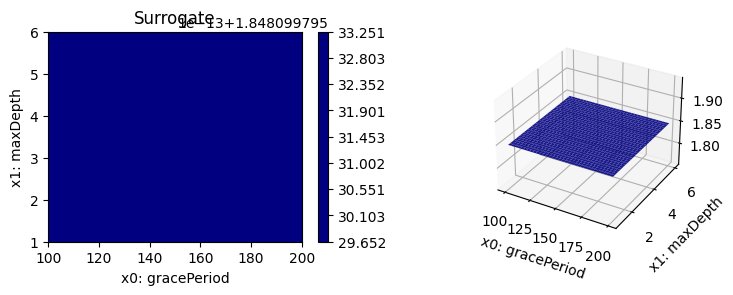

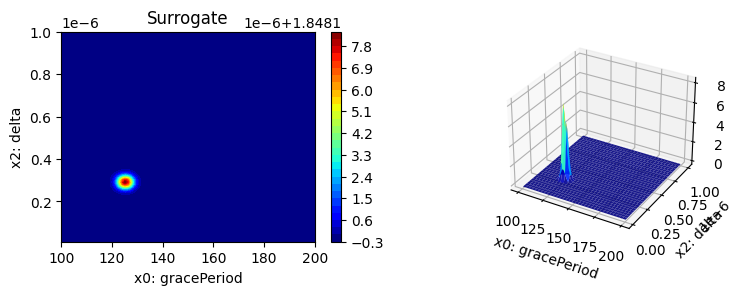

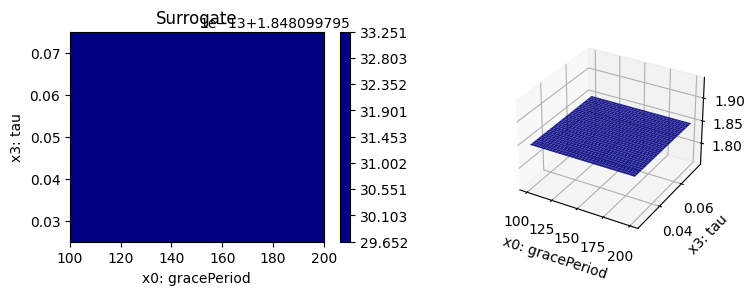

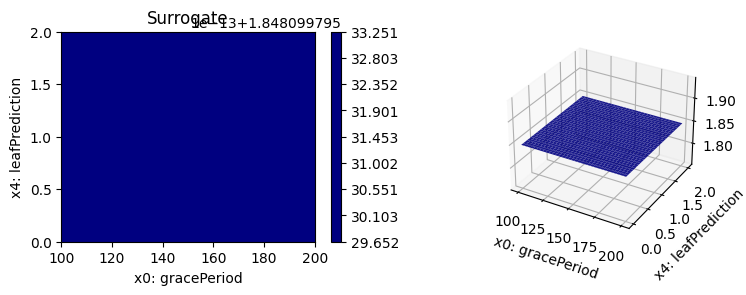

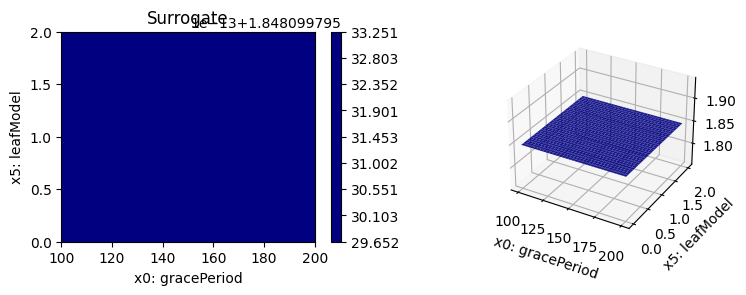

In [23]:
min(spot_htr.y), max(spot_htr.y)
n = spot_htr.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_htr.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)